## Fake Review Detection via Machine Learning

### Objective
Develop a machine learning model to identify fake online reviews using classification algorithms like Logistic Regression, SVM, and Random Forest.

### Methodology
- Preprocess review text data
- Train multiple classification models
- Evaluate model performance and detection accuracy

### Expected Outcomes
- Precisely identify fabricated online reviews with high accuracy
- Contribute to understanding the digital landscape of online review authenticity and misinformation detection

### Data Source
- **Source:** [Fake Reviews Dataset](https://www.kaggle.com/datasets/mexwell/fake-reviews-dataset/data)  
- **Description:** The dataset contains online reviews labeled as either genuine or fake. It includes:
  - Review text.
  - Metadata such as product ratings and categories, which were leveraged for analysis and model building. 

#### Import and Setup

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Load the data
df = pd.read_csv('data/fake_reviews_dataset.csv')
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [12]:
unique_categories = df['category'].nunique()
print(f'There are {unique_categories} unique categories.')

There are 10 unique categories.


In [ ]:
# Remove category as it provides no useful information

df = df.drop(columns=['category'])
df.head()

,rating,label,text_
0,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,5.0,CG,"love it, a great upgrade from the original. I..."
2,5.0,CG,This pillow saved my back. I love the look and...
3,1.0,CG,"Missing information on how to use it, but it i..."
4,5.0,CG,Very nice set. Good quality. We have had the s...


In [14]:
# Convert label to binary
df['label_binary'] = df['label'].map({'CG': 1, 'OR': 0})
#remove the original label column
df = df.drop(columns=['label'])
# Display the dataframe with the new binary label column
df.head(10)

,rating,text_,label_binary
0,5.0,"Love this! Well made, sturdy, and very comfor...",1
1,5.0,"love it, a great upgrade from the original. I...",1
2,5.0,This pillow saved my back. I love the look and...,1
3,1.0,"Missing information on how to use it, but it i...",1
4,5.0,Very nice set. Good quality. We have had the s...,1
5,3.0,I WANTED DIFFERENT FLAVORS BUT THEY ARE NOT.,1
6,5.0,They are the perfect touch for me and the only...,1
7,3.0,These done fit well and look great. I love th...,1
8,5.0,"Great big numbers & easy to read, the only thi...",1
9,5.0,My son loves this comforter and it is very wel...,1


In [15]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back to a single string
    return ' '.join(tokens)

# Apply preprocessing to the "text_" column
df['cleaned_text'] = df['text_'].apply(preprocess_text)

# Display the dataframe with the new cleaned text column
df.head(10)

[nltk_data] Downloading package punkt to /Users/test/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/test/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/test/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,rating,text_,label_binary,cleaned_text
0,5.0,"Love this! Well made, sturdy, and very comfor...",1,love well made sturdy comfortable love itvery ...
1,5.0,"love it, a great upgrade from the original. I...",1,love great upgrade original ive mine couple year
2,5.0,This pillow saved my back. I love the look and...,1,pillow saved back love look feel pillow
3,1.0,"Missing information on how to use it, but it i...",1,missing information use great product price
4,5.0,Very nice set. Good quality. We have had the s...,1,nice set good quality set two month
5,3.0,I WANTED DIFFERENT FLAVORS BUT THEY ARE NOT.,1,wanted different flavor
6,5.0,They are the perfect touch for me and the only...,1,perfect touch thing wish little space
7,3.0,These done fit well and look great. I love th...,1,done fit well look great love smoothness edge ...
8,5.0,"Great big numbers & easy to read, the only thi...",1,great big number easy read thing didnt like size
9,5.0,My son loves this comforter and it is very wel...,1,son love comforter well made also baby


In [16]:
# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment scores for each review
def get_sentiment_scores(text):
    sentiment = sentiment_analyzer.polarity_scores(text)
    return sentiment['compound']  # Using the compound score as it summarizes sentiment

# Apply the function to the 'cleaned_text' column
df['sentiment_score'] = df['text_'].apply(get_sentiment_scores)

# Drop the 'text_' column as it is no longer needed
df = df.drop(columns=['text_'])

# Display the updated dataframe
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/test/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,rating,label_binary,cleaned_text,sentiment_score
0,5.0,1,love well made sturdy comfortable love itvery ...,0.9593
1,5.0,1,love great upgrade original ive mine couple year,0.8910
2,5.0,1,pillow saved back love look feel pillow,0.7906
3,1.0,1,missing information use great product price,0.7463
4,5.0,1,nice set good quality set two month,0.7397


##### It appears there is not a strong correlation between the sentiment and the rating.  Based on this information, we will continue using sentiment in our analysis.

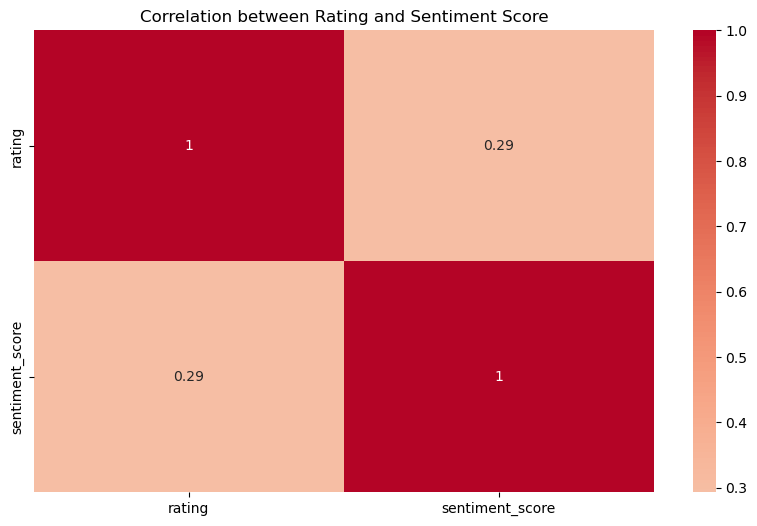

In [ ]:
# Plot the correlation between rating and sentiment score
plt.figure(figsize=(10, 6))
sns.heatmap(df[['rating', 'sentiment_score']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Rating and Sentiment Score')
plt.show()

#### Prepare the data for training and testing


In [ ]:
# Define features and target
X = df[['cleaned_text', 'rating', 'sentiment_score']]
y = df['label_binary']  # Target column

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Apply TF-IDF transformation to the 'cleaned_text' column
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform TF-IDF on the training text data, and transform on the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_text'])

# Convert the sparse TF-IDF matrix to a dense format
X_train_tfidf_dense = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_test_tfidf_dense = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Reset index for concatenation
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Concatenate TF-IDF features with additional numerical features
X_train_final = pd.concat([X_train_tfidf_dense, X_train[['rating', 'sentiment_score']]], axis=1)
X_test_final = pd.concat([X_test_tfidf_dense, X_test[['rating', 'sentiment_score']]], axis=1)

### Model Evaluation 

In [ ]:
# Initialize and train Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_final, Y_train)

# Predict on the test set
y_pred = logreg.predict(X_test_final)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
report = classification_report(Y_test, y_pred)

# Display the results
accuracy, report

(0.8697071626434507,
 '              precision    recall  f1-score   support\n\n           0       0.86      0.88      0.87      5070\n           1       0.88      0.85      0.87      5038\n\n    accuracy                           0.87     10108\n   macro avg       0.87      0.87      0.87     10108\nweighted avg       0.87      0.87      0.87     10108\n')

In [ ]:
# Define parameter grid for Logistic Regression
param_grid_logreg = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize and fit GridSearchCV for Logistic Regression
print("Initializing GridSearchCV for Logistic Regression...")
grid_search_logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logreg, cv=5, scoring='accuracy', verbose=10)

print("Fitting Logistic Regression model...")
grid_search_logreg.fit(X_train_final, Y_train)
print("Logistic Regression model fitted.")

# Get the best parameters and best score for Logistic Regression
best_params_logreg = grid_search_logreg.best_params_
best_score_logreg = grid_search_logreg.best_score_
print(f"Best parameters for Logistic Regression: {best_params_logreg}")
print(f"Best score for Logistic Regression: {best_score_logreg:.4f}")

# Initialize and fit GridSearchCV for SVM
print("\nInitializing GridSearchCV for SVM...")
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)

print("Fitting SVM model...")
grid_search_svm.fit(X_train_final, Y_train)
print("SVM model fitted.")

# Get the best parameters and best score for SVM
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_
print(f"Best parameters for SVM: {best_params_svm}")
print(f"Best score for SVM: {best_score_svm:.4f}")

# Initialize and fit GridSearchCV for Random Forest
print("\nInitializing GridSearchCV for Random Forest...")
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy', verbose=10)

print("Fitting Random Forest model...")
grid_search_rf.fit(X_train_final, Y_train)
print("Random Forest model fitted.")

# Get the best parameters and best score for Random Forest
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_
print(f"Best parameters for Random Forest: {best_params_rf}")
print(f"Best score for Random Forest: {best_score_rf:.4f}")

# Return the results
best_params_logreg, best_score_logreg, best_params_svm, best_score_svm, best_params_rf, best_score_rf


#### **Notebook output refined:**
##### Removed extensive processing logs that were initially added to track progress during a time-consuming computational task, while preserving the complete original results.  
- Final results of the run are located below.
- [Link to the detailed log file](data/TrainingLogs.txt)

#### GridSearchCV results for each model along with accuracy scoring for each model

- Logistic Regression model fitted.
    - Best parameters for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}
    - Best score for Logistic Regression: 0.8718

- SVM model fitted.
    - Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
    - Best score for SVM: 0.874

- Random Forest model fitted.
    - Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
    - Best score for Random Forest: 0.844


#### Create confusion matrix for each model with best GridSearchCV parameters

Confusion Matrix for Logistic Regression:
[[4429  641]
 [ 645 4393]]


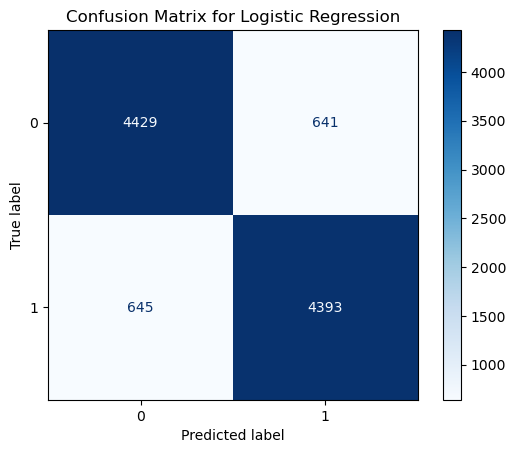

Confusion Matrix for SVM:
[[4589  481]
 [ 581 4457]]


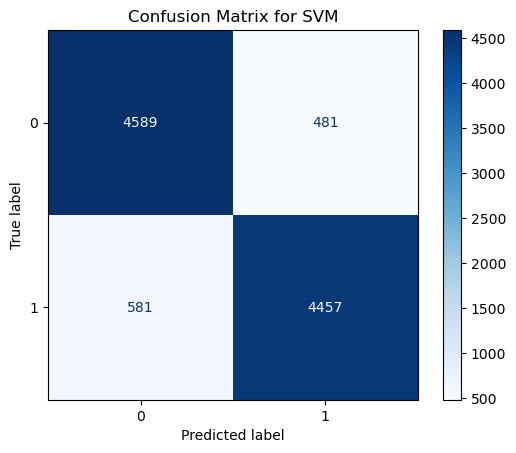

Confusion Matrix for Random Forest:
[[4147  923]
 [ 656 4382]]


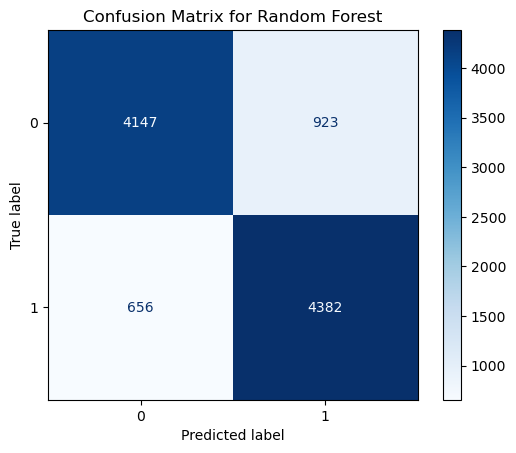

In [ ]:

# Initialize and train each model with best parameters then test on the test set and plot confusion matrix for each.

# Train Logistic Regression model with best parameters
logreg_best = LogisticRegression(C=10, solver='lbfgs', max_iter=1000)
logreg_best.fit(X_train_tfidf, Y_train)
y_pred_logreg = logreg_best.predict(X_test_tfidf)
cm_logreg = confusion_matrix(Y_test, y_pred_logreg)

print("Confusion Matrix for Logistic Regression:")
print(cm_logreg)

# Plot confusion matrix for Logistic Regression
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=logreg_best.classes_)
disp_logreg.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# Train SVM model with best parameters
svm_best = SVC(C=10, gamma='scale', kernel='rbf')
svm_best.fit(X_train_tfidf, Y_train)
y_pred_svm = svm_best.predict(X_test_tfidf)
cm_svm = confusion_matrix(Y_test, y_pred_svm)

print("Confusion Matrix for SVM:")
print(cm_svm)

# Plot confusion matrix for SVM
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_best.classes_)
disp_svm.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM")
plt.show()

# Train Random Forest model with best parameters
rf_best = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200)
rf_best.fit(X_train_tfidf, Y_train)
y_pred_rf = rf_best.predict(X_test_tfidf)
cm_rf = confusion_matrix(Y_test, y_pred_rf)

print("Confusion Matrix for Random Forest:")
print(cm_rf)

# Plot confusion matrix for Random Forest
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_best.classes_)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest")
plt.show()


#### SVG selected as best option